In [1]:
import sys
sys.path.append('/opt/ml/code')

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_modules.transform import get_transform
from my_modules.dataset import TrainDataset, EvalDataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from efficientnet_pytorch import EfficientNet

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
## hyperparameters

model_name = 'efficientnet-b0'
device = 'cuda'
batch_size = 64
target = 'age'

df_test_path = '/opt/ml/input/data/eval/info.csv'
df_test = pd.read_csv(df_test_path)

In [4]:
input_size = EfficientNet.get_image_size(model_name)
print(input_size)

224


In [5]:
## transform

transform_test = get_transform(augment=False, crop=350, resize=input_size, cutout=None)

In [6]:
## prepare dataset

test_dataset = EvalDataset(df=df_test, transform=transform_test)

In [7]:
## prepare dataloader

dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, drop_last=False, shuffle=False)

In [8]:
## prepare model

if model_name.startswith('efficientnet'):
    model = EfficientNet.from_pretrained(model_name, num_classes=2 if target=='gender' else 3)
elif model_name.startswith('tf'):
    import timm
    model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=2 if target=='gender' else 3)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
    
model.to(device)
print(model_name, 'ready')

Loaded pretrained weights for efficientnet-b0
efficientnet-b0 ready


In [ ]:
# check input train batch

from my_modules.utils import imshow
batch = next(iter(dataloader))
imshow(batch)
#print(batch[1])

## Test

In [10]:
import torch.nn.functional as F
from tqdm import tqdm

model.eval()

hard_preds = []
soft_preds = []

with torch.no_grad():

    for fold in range(1,3):

        hard_pred = []
        soft_pred = []

        model.load_state_dict(torch.load(f'/opt/ml/code/save/age_pseudo/fold{fold}.pt'))
        print(f'starting fold{fold}...')

        for inputs in tqdm(dataloader):

            inputs = inputs.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            prob =F.softmax(outputs, dim=-1)
            
            hard_pred.append(preds.cpu().numpy())
            soft_pred.append(prob.cpu().numpy())
    
        hard_preds.append(np.concatenate(hard_pred, axis=0))
        soft_preds.append(np.concatenate(soft_pred, axis=0))
        
        print(f'finished fold{fold}!')
    

starting fold1...


100%|██████████| 197/197 [00:32<00:00,  6.03it/s]


finished fold1!
starting fold2...


100%|██████████| 197/197 [00:33<00:00,  5.88it/s]

finished fold2!


In [11]:
hard_vote = []

for preds_ in zip(*hard_preds):
    hard_vote.append(np.bincount(preds_).argmax())

In [12]:
np.bincount(hard_vote)

array([5368, 3687, 3545])

In [13]:
prob = np.mean(soft_preds, axis=0)

In [14]:
soft_vote = np.sum(soft_preds, axis=0).argmax(axis=-1)

In [15]:
np.bincount(soft_vote)

array([5355, 3516, 3729])

In [ ]:
a = (sort_idx[:, 0])[np.nonzero(soft_vote == 0)[0]]

In [ ]:
sort_idx = prob.argsort(axis=0)
a = [idx for idx in sort_idx[:, 0] if idx in np.nonzero(soft_vote == 0)[0]]

In [ ]:
from PIL import Image
import os
i = 0

In [ ]:
[0.8, 0.8, 0.8]

In [ ]:
fig, axes = plt.subplots(5, 8, figsize=(15, 15))
for ax in axes.flatten():
    try:
        img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[a[i]]['ImageID']))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{a[i]}, {[round(p, 3) for p in prob[a[i]]]}', fontsize=7)
        ax.set_xlabel(f'')
        i += 1
    except:
        pass

plt.show()

In [ ]:
idx_filtered = np.nonzero(np.any(prob >= np.array([0.9, 0.9]), axis=1))[0]

In [ ]:
df_test['gender'] = hard_vote
df_filtered = df_test.iloc[idx_filtered].copy()

In [ ]:
df_filtered['path'] = '/opt/ml/input/data/eval/images/' + df_filtered['ImageID']
df_filtered

In [ ]:
df_filtered.to_csv('df/df_gender_filtered.csv' ,index=False)

In [ ]:
i += 1

img_pil = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[i]['ImageID']))

fig, axes = plt.subplots(1, 10 + 1, figsize=(15, 5))
axes[0].imshow(img_pil)
axes[0].axis('off')
axes[0].set_title('query')
print(i)
for ax, idx in zip(axes[1:], sim_idxs[i]):
    img = Image.open(df_key.iloc[idx]['path'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(df_key.iloc[idx]['age'])

plt.show()

In [37]:
import pickle
with open('pkl/psedo_age.pkl', 'rb') as f:
    age_pred = pickle.load(f)

df_test['age'] = age_pred

In [39]:
df_test.to_csv('df/final.csv', index=False)

In [35]:
import pickle

with open(f'pkl/{target}_pseudo_ensemble_soft.pkl', 'wb') as f:
    pickle.dump(soft_vote, f)

with open(f'pkl/{target}_pseudo_ensemble_hard.pkl', 'wb') as f:
    pickle.dump(hard_vote, f)

In [16]:
disagree = []

for i in range(len(df_test)):
    if soft_vote[i] != hard_vote[i]:
        disagree.append(i)

In [17]:
disagree

[19,
 50,
 114,
 120,
 150,
 225,
 227,
 389,
 475,
 539,
 561,
 635,
 703,
 743,
 753,
 793,
 982,
 1061,
 1077,
 1169,
 1174,
 1231,
 1290,
 1345,
 1374,
 1460,
 1654,
 1679,
 1755,
 1934,
 1954,
 2136,
 2225,
 2254,
 2260,
 2328,
 2497,
 2513,
 2532,
 2592,
 2640,
 2823,
 2852,
 2957,
 2969,
 3089,
 3149,
 3179,
 3193,
 3212,
 3228,
 3290,
 3291,
 3338,
 3441,
 3507,
 3527,
 3529,
 3551,
 3594,
 3680,
 3732,
 3736,
 3737,
 3781,
 3809,
 3860,
 4030,
 4067,
 4116,
 4239,
 4264,
 4317,
 4394,
 4465,
 4485,
 4533,
 4547,
 4560,
 4699,
 4917,
 5046,
 5081,
 5154,
 5194,
 5305,
 5313,
 5466,
 5496,
 5590,
 5600,
 5736,
 5979,
 5982,
 6061,
 6095,
 6102,
 6137,
 6316,
 6370,
 6375,
 6416,
 6431,
 6521,
 6636,
 6679,
 6759,
 6764,
 6801,
 6827,
 6831,
 6859,
 6870,
 6948,
 6967,
 7018,
 7119,
 7126,
 7147,
 7157,
 7168,
 7256,
 7368,
 7396,
 7400,
 7418,
 7421,
 7566,
 7574,
 7575,
 7654,
 7739,
 7971,
 8051,
 8066,
 8172,
 8240,
 8327,
 8389,
 8415,
 8430,
 8432,
 8530,
 8645,
 8696,
 882

In [20]:
from PIL import Image
import os

In [21]:
i = -1
gender=['y', 'm', 'o']

13/197  soft vote : o, hard vote : m


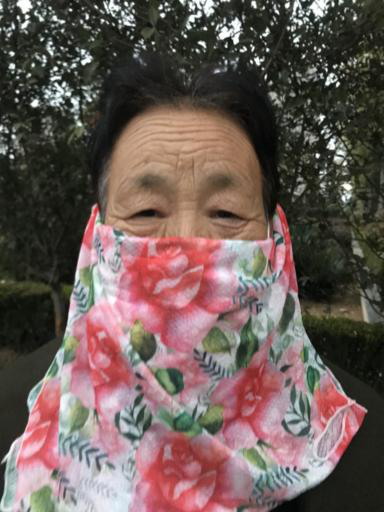

In [34]:
i += 1
idx = disagree[i]
print(f'{i+1}/{len(disagree)}  soft vote : {gender[soft_vote[idx]]}, hard vote : {gender[hard_vote[idx]]}')
img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[idx]['ImageID']))
img

In [ ]:
soft 3
hard 3
? ..

In [ ]:
disagree